# Category-based Subspace Attention Network

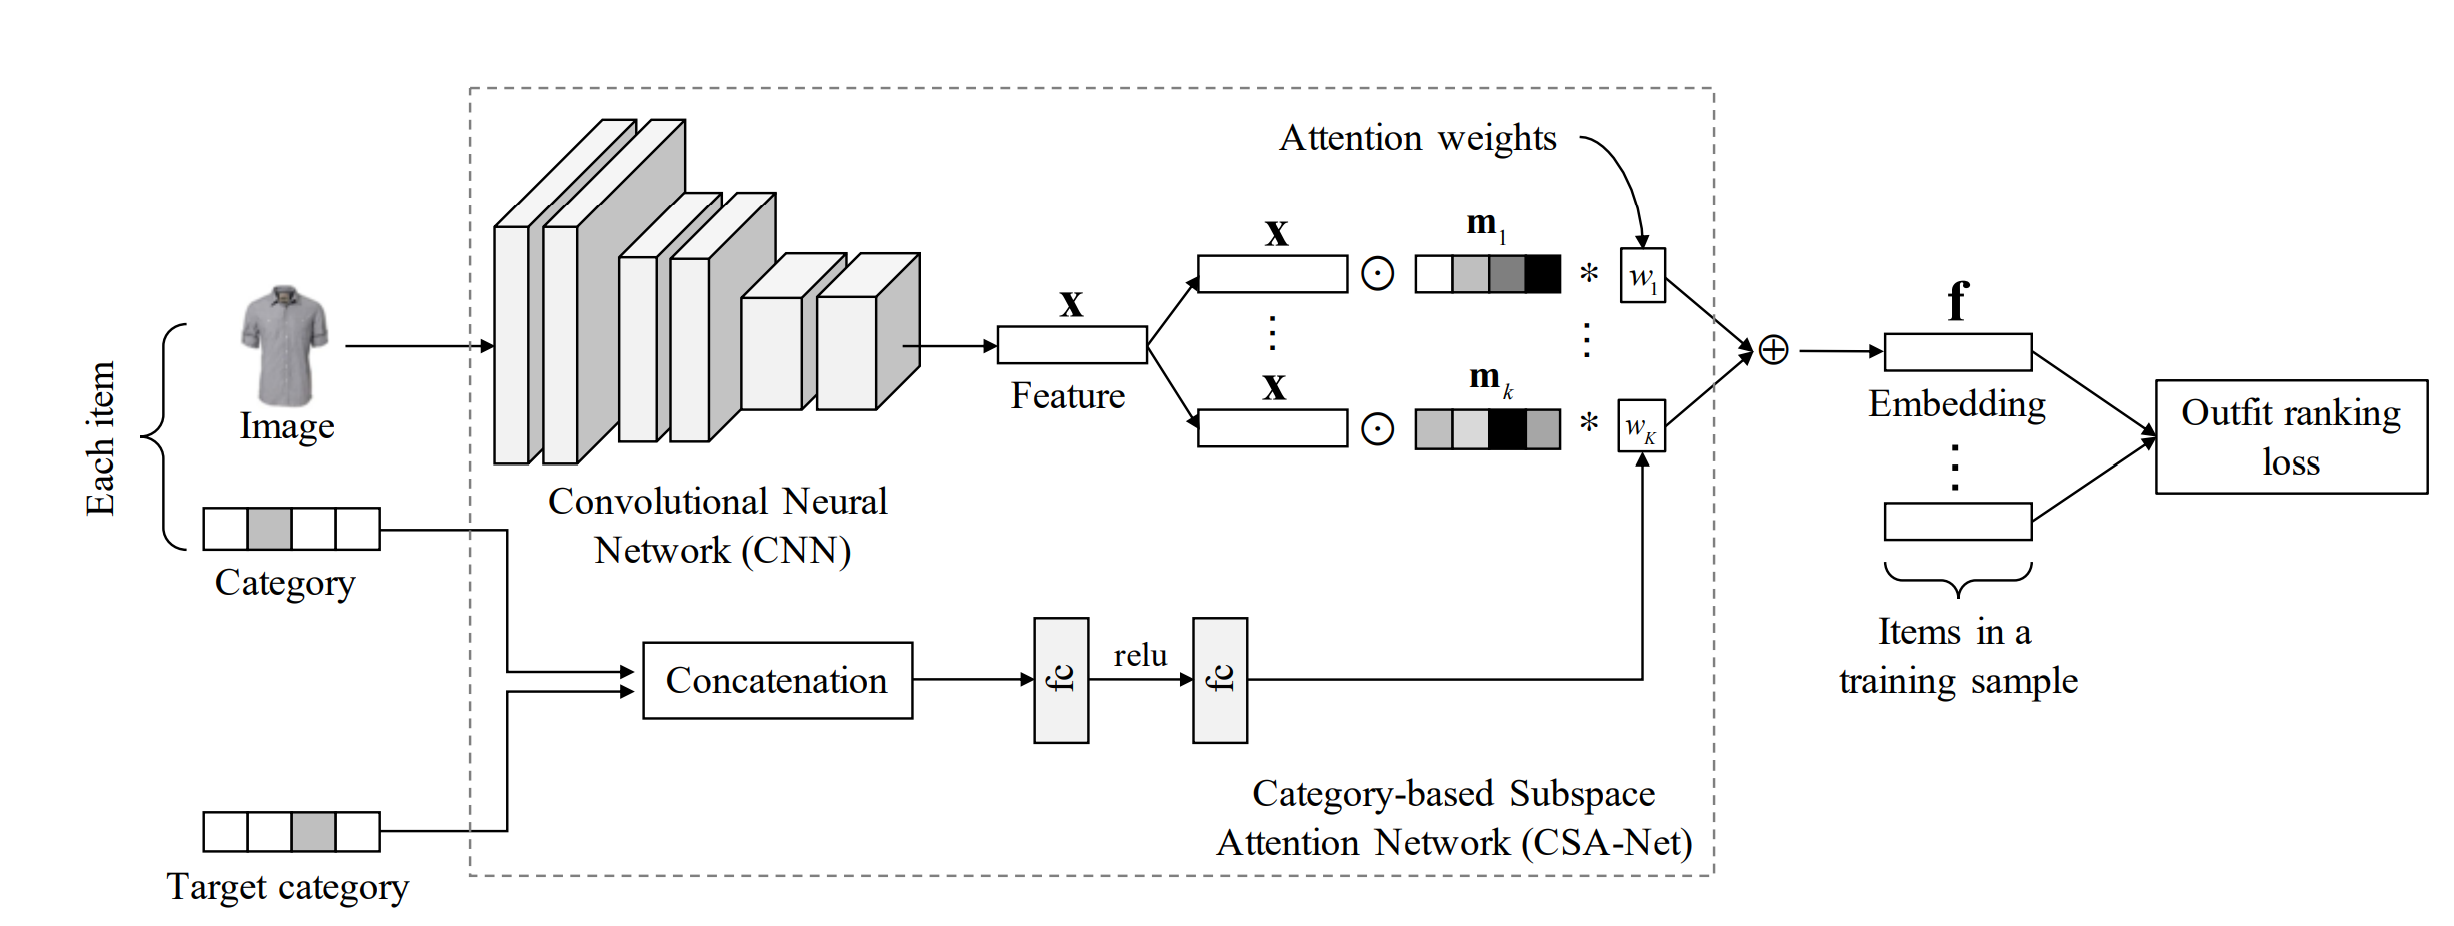

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
from collections import Counter
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tqdm import tqdm
import pickle

import sys
# sys.path.insert(0, "/recsys_data/RecSys/fashion/automl/efficientnetv2")
# import effnetv2_model

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
tf.__version__

'2.2.0'

In [4]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
data_type = "nondisjoint" # "nondisjoint", "disjoint"
train_dir = os.path.join(base_dir, data_type)
image_dir = os.path.join(base_dir, "images")
embed_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/precomputed"
train_json = "train.json"
valid_json = "valid.json"
test_json = "test.json"

train_file = "compatibility_train.txt"
valid_file = "compatibility_valid.txt"
test_file = "compatibility_test.txt"
item_file = "polyvore_item_metadata.json"
outfit_file = "polyvore_outfit_titles.json"

In [5]:
with open(os.path.join(train_dir, train_json), 'r') as fr:
    train_pos = json.load(fr)
    
with open(os.path.join(train_dir, valid_json), 'r') as fr:
    valid_pos = json.load(fr)
    
with open(os.path.join(train_dir, test_json), 'r') as fr:
    test_pos = json.load(fr)
    
with open(os.path.join(base_dir, item_file), 'r') as fr:
    pv_items = json.load(fr)
    
print(f"Total {len(train_pos)}, {len(valid_pos)}, {len(test_pos)} outfits in train, validation and test split, respectively")

Total 53306, 5000, 10000 outfits in train, validation and test split, respectively


## Generate triplet samples

    - a sample will contain (1) an outfit, (2) a positive image that is compatible and (3) a set of negatives images that are not compatible with the outfit
    - each image is also accompanied by it's category

In [6]:
from data_process import CSANetGen
batch_size = 32
image_embedding_flag = True
max_seq_len = 7

image_embedding_file = os.path.join(embed_dir, "effnet_tuned_polyvore.pkl")
text_embedding_file = os.path.join(embed_dir, "bert_polyvore.pkl")
train_gen = CSANetGen(train_pos, pv_items, 
                      batch_size=batch_size, 
                      image_embedding_file=image_embedding_file,
                      text_embedding_file=text_embedding_file,
                      max_example=None,
                      max_items=max_seq_len,
                      get_image_embedding=image_embedding_flag,
                      image_dir=image_dir,
                      mask_zero=True,
                      )

valid_gen = CSANetGen(valid_pos, pv_items, 
                      batch_size=batch_size, 
                      image_embedding_file=image_embedding_file,
                      text_embedding_file=text_embedding_file,
                      max_example=None,
                      max_items=max_seq_len,
                      get_image_embedding=image_embedding_flag,
                      image_dir=image_dir,
                      mask_zero=True,
                      )

Total 154 item categories


100%|██████████| 16995/16995 [00:57<00:00, 293.90it/s]


Total 16995 examples
Total 154 item categories


100%|██████████| 3000/3000 [00:10<00:00, 283.84it/s]


Total 3000 examples


In [7]:
for ii in range(2):
    inps, targs = train_gen[ii]
    print([x.shape for x in inps], targs.shape)

[(32, 7, 1280), (32, 1280), (32, 7, 1280), (32, 7), (32,), (32, 7)] (32,)
[(32, 7, 1280), (32, 1280), (32, 7, 1280), (32, 7), (32,), (32, 7)] (32,)


In [8]:
inps[3]

array([[  0,   0,   0,   5,  11,  60,  74],
       [  0,   0,   0,  94,  35,  10,   7],
       [  0,   0,   0, 106,  11,  12,  36],
       [  0,   0,   0,   0,  25,  28,  41],
       [  0,  25,   9,  17,  12,  69,  21],
       [  0,   0,   0,  24,  17,  60,  23],
       [  0,   0,   0,   5,  44,  59,   4],
       [  0,   0,   0,   5,  19,  39,  30],
       [  0,   0,   0,   0,   5,  19,  17],
       [  0,  34,  64,  44,  37,  26,  74],
       [  0,   0,   0,  54,  44,  38,   7],
       [  0,   0,   0,  20,  44,  79,   4],
       [  0,   0,   5,  28,  37,  12,  35],
       [  0,   0,   0,  24,  28,   8,  36],
       [  0,   0,   0,   5,  11,  12,  60],
       [  0,   0,   0,  25,  11,  36,  51],
       [ 24,  28,   3,   9,  39,  37,  36],
       [  0,   0,  28,  53,  35,   7,   6],
       [  0,   0,  24,   3,  15,  12,  29],
       [  0,   0,   0,  25,  39,   2,  23],
       [  0, 139, 149, 128, 119,  88, 141],
       [  0,   0,   0,  24,  28,  39,  29],
       [  0,   0,  20,   8, 119,

In [9]:
inps[3] == inps[5]

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,

In [38]:
def plot_sample(batch_data, max_example=5):
    outfits = batch_data[0]
    positives = batch_data[1]
    negatives = batch_data[2]
    indices = np.random.randint(low=0, high=outfits.shape[0]-1, size=max_example)
    masks = np.sum(inps[0], axis=(2,3,4))>0.0
    for ii in indices:
        nrows, ncols = 1, sum(mask[ii]) * 2 + 1
        figure, axis = plt.subplots(nrows, ncols, figsize=(20,5))

        outfit_images = [images for images, mask in zip(outfits[ii], masks[ii]) if mask] 
        positive = positives[ii]
        negative_images = [images for images, mask in zip(negatives[ii], masks[ii]) if mask]
        items = outfit_images + [positive] + negative_images
        for ii in range(ncols):
            img = items[ii]
            imgplot = axis[ii].imshow(img)
            axis[ii].axis('off')
        plt.show()


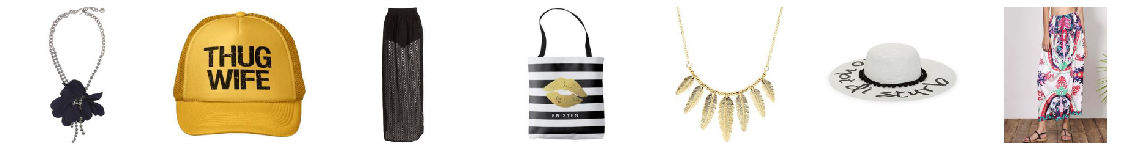

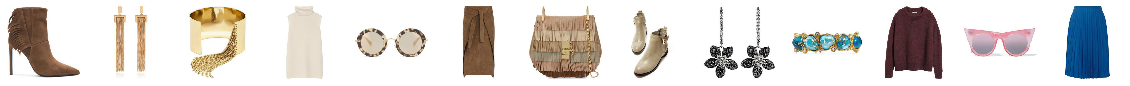

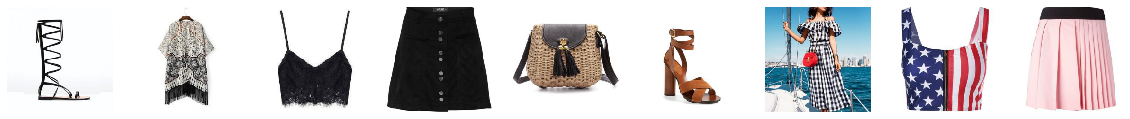

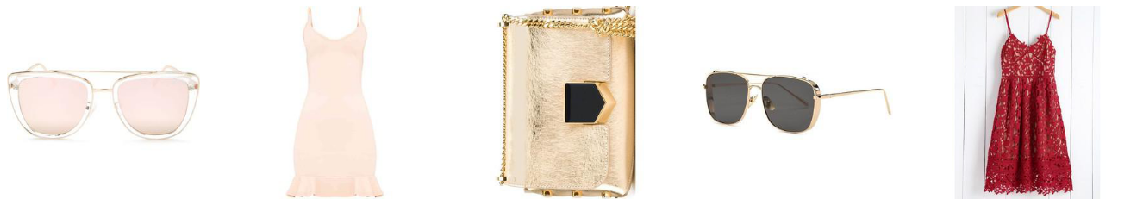

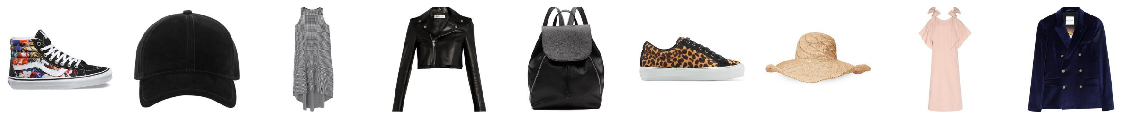

In [39]:
plot_sample(inps)

## Build CSE-Net Model

In [49]:
from csenet import build_csenet

model = build_csenet(inp_seq_len=max_seq_len,
#                      image_dim=(224, 224, 3),
                     image_dim=1280,
                     margin=0.3,
                     mask_zero=False,
                     num_categories=154,
                     num_subspace=6,
                    )

model.summary()

Model: "cse-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           [(None, 7, 1280)]    0                                            
__________________________________________________________________________________________________
input_72 (InputLayer)           [(None, 1280)]       0                                            
__________________________________________________________________________________________________
time_distributed_15 (TimeDistri (None, 7, 64)        81984       input_73[0][0]                   
__________________________________________________________________________________________________
input_71 (InputLayer)           [(None, 7, 1280)]    0                                            
____________________________________________________________________________________________

In [50]:
learning_rate = 1.0e-04
epochs = 2
patience = 6
batch_size = batch_size
checkpoint_filepath = base_dir + '/checkpoint'

opt = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss="mse", optimizer=opt, metrics=["mse", "mae"])  # 
callback = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=patience,
                        verbose=0,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=True,
                    )

# wandb_callback = WandbCallback(
#                         monitor="val_loss",
#                         verbose=0,
#                         save_model=(False), 
#                         mode="auto")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-06)

tic = time.time()
# run = wandb.init(reinit=True)
if 'history' in locals():
    history_prev = history
history = model.fit(train_gen, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=valid_gen,
                    validation_batch_size=batch_size,
                    validation_freq=1,
                    callbacks=[callback, reduce_lr],
                    verbose=1)
# run.finish()
time.time() - tic

Epoch 1/2
532/532 [==============================] - 12s 22ms/step - loss: 4.2077e-04 - mse: 4.2006e-04 - mae: 0.0030 - val_loss: 3.1248e-05 - val_mse: 3.1165e-05 - val_mae: 3.8722e-04 - lr: 1.0000e-04
Epoch 2/2
532/532 [==============================] - 10s 20ms/step - loss: 1.3240e-05 - mse: 1.3217e-05 - mae: 1.9509e-04 - val_loss: 1.1429e-05 - val_mse: 1.1399e-05 - val_mae: 1.5237e-04 - lr: 1.0000e-04


28.734610319137573

In [51]:
max_seq_len = 7
model.save(f"csenet_model_{max_seq_len}")

AttributeError: 'Tensor' object has no attribute '_keras_mask'

## Sub-model to extract item representation

- inputs are, an item image, it's category and another category (for which combination the representation is sought)

In [52]:
model.layers[31]

In [53]:
inp_image = tf.keras.layers.Input(shape=(1280))
# inp_outfit_images = tf.keras.layers.Input(shape=(7, 1280))
inp_outfit_images = tf.keras.layers.RepeatVector(7)(inp_image)
inp_pos_cat = tf.keras.layers.Input(shape=())
inp_outfit_cats = tf.keras.layers.Input(shape=(7,))
outfit_images_embedded = model.layers[2](inp_outfit_images)
attn_out = model.layers[31]([outfit_images_embedded, inp_outfit_cats, inp_pos_cat])
model_ = tf.keras.models.Model(inputs=[inp_image, inp_pos_cat, inp_outfit_cats], outputs=attn_out)
model_.summary()

AttributeError: 'Tensor' object has no attribute '_keras_mask'

In [34]:
with open(image_embedding_file, "rb") as fr:
    image_embedding_dict = pickle.load(fr)


In [46]:
def evaluate_item(item_id, category_1, category_2, max_items=7):
    x = image_embedding_dict[item_id]
    x = np.expand_dims(x, axis=0)
    inp_category = np.array([[category_1] * max_items])
    y = model_([x, inp_category, np.array([[category_2]])])
    return y

In [47]:
items = list(image_embedding_dict.keys())

In [48]:
evaluate_item(items[0], 0, 1)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute '_keras_mask'

## Different Model

- Binary Cross-entropy loss:
    - inputs: an outfit, an item - positive or negative and the label is accordingly set
    
- Triplet loss: 
    - inputs: an outfit, a positive item and a negative item

Duplicate items in an outfit

In [6]:
for ii in range(len(train_pos)):
    items = [x['item_id'] for x in train_pos[ii]['items']]
    if len(items) != len(set(items)):
        print(ii, items)

1463 ['213844505', '213505203', '213518572', '204336530', '202290027', '202290027']
2096 ['82300860', '82300860', '158608273', '138471912', '174176796', '156470094']
2648 ['212014957', '213523809', '206842347', '213382499', '213382499', '214699628']
3269 ['193137785', '193137785', '200164395', '199645102', '192913895', '199931311', '199119476', '200263460']
7186 ['213704917', '212862267', '214252148', '214252148']
7392 ['209229490', '209229490', '213548598', '172626310', '201292508', '212429203']
12188 ['173300459', '101828445', '169229877', '123846367', '168383870', '168383870', '146288612']
16237 ['213480904', '212306894', '212640836', '203633464', '203633464', '212933984', '174008996']
18354 ['215017037', '210499460', '200197191', '161594174', '211560047', '211560047', '204171756']
21760 ['189888981', '189888981', '209203966', '161205227', '182141404', '184499873']
25521 ['207584606', '206874194', '213412278', '210709237', '210709237']
25578 ['209065664', '213813026', '213085616', '

In [25]:
from data_process import KTupleGen

batch_size = 32
image_embedding_flag = True
max_seq_len = 6
loss = "binary-crossentropy"

image_embedding_file = os.path.join(embed_dir, "effnet_tuned_polyvore.pkl")
text_embedding_file = os.path.join(embed_dir, "bert_polyvore.pkl")
train_gen = KTupleGen(train_pos, pv_items, 
                      batch_size=batch_size, 
                      image_embedding_file=image_embedding_file,
                      text_embedding_file=text_embedding_file,
                      max_example=None,
                      max_outfit_length=max_seq_len,
                      get_image_embedding=image_embedding_flag,
                      image_dir=image_dir,
                      loss_type=loss,
                      hard_negative=True,
                      fraction=0.5,
                      get_text_embedding=True,
                      )

valid_gen = KTupleGen(valid_pos, pv_items, 
                      batch_size=batch_size, 
                      image_embedding_file=image_embedding_file,
                      text_embedding_file=text_embedding_file,
                      max_example=None,
                      max_outfit_length=max_seq_len,
                      get_image_embedding=image_embedding_flag,
                      image_dir=image_dir,
                      loss_type=loss,
                      hard_negative=True,
                      fraction=0.5,
                      get_text_embedding=True,
                      )

Total 153 item categories


100%|██████████| 53306/53306 [09:12<00:00, 96.51it/s]  


Total 636816 examples
Total 153 item categories


100%|██████████| 5000/5000 [00:42<00:00, 117.50it/s]


Total 47892 examples


In [26]:
for ii in range(2):
    inps, targs = train_gen[ii]
    print([x.shape for x in inps], targs.shape)

TypeError: 'bool' object is not callable

In [23]:
from csanet import build_csanet2

model = build_csanet2(inp_seq_len=max_seq_len,
#                      image_dim=(224, 224, 3),
                      image_dim=1280,
                      image_embedding_dim=256,
                      category_embedding_dim=256,
                      embedding_activation="tanh",
                      d_model=256,
                      margin=0.3,
                      num_categories=153,
                      num_subspace=6,
                      loss_type=loss,
                      final_activation="sigmoid",
                     )

model.summary()

Model: "CSA-net-II"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           [(None, 1280)]       0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           [(None, 6, 1280)]    0                                            
_________________________________________________________________________________________

In [10]:
loss

'binary-crossentropy'

In [24]:
learning_rate = 1.0e-04
epochs = 100
patience = 6
batch_size = batch_size
checkpoint_filepath = base_dir + '/checkpoint'

opt = keras.optimizers.Adam(learning_rate=learning_rate)
if "triplet" in loss.lower():
    model.compile(loss="mse", optimizer=opt, metrics=["mse", "mae"])  # 
elif "binary" in loss.lower():
    loss_ = tf.keras.losses.BinaryCrossentropy(from_logits=False, name='binary_crossentropy')
    model.compile(loss=loss_, optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC()])
    
callback = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=patience,
                        verbose=0,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=True,
                    )

# wandb_callback = WandbCallback(
#                         monitor="val_loss",
#                         verbose=0,
#                         save_model=(False), 
#                         mode="auto")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-06)

tic = time.time()
# run = wandb.init(reinit=True)
if 'history' in locals():
    history_prev = history
history = model.fit(train_gen, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=valid_gen,
                    validation_batch_size=batch_size,
                    validation_freq=1,
                    callbacks=[callback, reduce_lr],
                    verbose=1)
# run.finish()
time.time() - tic

Epoch 1/100
19901/19901 [==============================] - 220s 11ms/step - loss: 0.5850 - accuracy: 0.6495 - auc_1: 0.7268 - val_loss: 0.6839 - val_accuracy: 0.5799 - val_auc_1: 0.6115 - lr: 1.0000e-04
Epoch 2/100
19901/19901 [==============================] - 219s 11ms/step - loss: 0.4899 - accuracy: 0.7366 - auc_1: 0.8292 - val_loss: 0.6814 - val_accuracy: 0.5920 - val_auc_1: 0.6371 - lr: 1.0000e-04
Epoch 3/100
19901/19901 [==============================] - 220s 11ms/step - loss: 0.4348 - accuracy: 0.7778 - auc_1: 0.8719 - val_loss: 0.7033 - val_accuracy: 0.5977 - val_auc_1: 0.6427 - lr: 1.0000e-04
Epoch 4/100
19901/19901 [==============================] - 218s 11ms/step - loss: 0.3920 - accuracy: 0.8088 - auc_1: 0.8994 - val_loss: 0.7216 - val_accuracy: 0.5935 - val_auc_1: 0.6431 - lr: 1.0000e-04
Epoch 5/100
19901/19901 [==============================] - 219s 11ms/step - loss: 0.3563 - accuracy: 0.8313 - auc_1: 0.9189 - val_loss: 0.7223 - val_accuracy: 0.5990 - val_auc_1: 0.6396 - 

1758.3077101707458